In [183]:
#0.7 Pytorch Experiment Tracking

In [210]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
import data_setup
import engine
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import save_model

In [211]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()


In [212]:
# Get data of pizza, steak, sushi with helper function

import os
import zipfile
from pathlib import Path
import requests

def download_data(
        source: str,
        destination: str,
        remove_source: bool = True) -> Path:
    """Downloads zipped dataset from source and unzips to destination"""
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print("Directory already exists, skipping download")
    else:
        image_path.mkdir(parents=True, exist_ok=True)
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print("Downloading target file from source")
            f.write(request.content)

        with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
            zip_ref.extractall(image_path)

        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path


In [187]:
image_path = download_data(source="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

Directory already exists, skipping download


In [188]:
# Create datasets and dataloaders

train_dir = image_path / "train"
test_dir = image_path / "test"

In [189]:
normalize = transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229, .224, .225])

manual_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manually created transforms: {manual_transform}")

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=32)

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [190]:
# Setup pretrained weights from PyTorch docs -> uses defaults that already work
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (transforms used to train a particular set of weights)
automatic_transforms = weights.transforms()

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_transforms,
                                                                               batch_size=32)

In [191]:
# Get a pretrained model, freeze base layers and change classifier head
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [192]:
# Freeze base layers by setting not tracking gradients
for param in model.features.parameters():
    param.requires_grad = False

In [193]:
set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [194]:
# Train a single model and track results

# Define loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [195]:
# We want to use tensorboard to track our stuff rather than just writing to a results dict
writer = SummaryWriter()

In [196]:
from engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 244, 244).to(device))
        
    writer.close()

    # Return the filled results at the end of the epochs
    return results

In [197]:
# Now lets check how to compare multiple models
# Create a function to prepare a summarywriter() instance
# Maybe we want to save different experiments to different folders (1 per)
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance for a specific directory"""
    from datetime import datetime

    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    return SummaryWriter(log_dir=log_dir)

In [198]:
example_writer = create_writer(experiment_name="data_10_percent",
                              model_name="effnetb0",
                              extra="5_epochs")

example_writer

In [199]:
from engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###

        if writer:
            writer.add_scalars(main_tag="Loss",
                            tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                            global_step=epoch)
            
            writer.add_scalars(main_tag="Accuracy",
                            tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                            global_step=epoch)
            
            writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 244, 244).to(device))
        
            writer.close()
        else:
            pass

    # Return the filled results at the end of the epochs
    return results

In [200]:
# Let's set up a series of different experiements:
#   - Model size (effnetb0 vs b2), dataset size (10% vs 20%), training time (5 epochs vs 10)
# We still want them to be fairly fast though so we know what doesn't work

In [201]:
### Download different datasets - 10% and 20%

data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination="pizza_steak_sushi_20")

Directory already exists, skipping download
Directory already exists, skipping download


In [202]:
### Turn datasets into dataloaders - need to resize our images to match EffNet format

train_dir_10 = data_10_percent_path / "train"
train_dir_20 = data_20_percent_path / "train"

test_dir = data_10_percent_path / "test"  # Only need the one dataset to test against - want to keep something constant

In [203]:
normalize = transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229, .224, .225])

# Compose transforms into pipeline
simple_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

In [213]:
BATCH_SIZE = 32

# 10% train and test dataloaders
train_dataloader_10, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10,
                                                                                  test_dir=test_dir,
                                                                                  transform=simple_transform,
                                                                                  batch_size=BATCH_SIZE)
# 20% train and test dataloaders
train_dataloader_20, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20,
                                                                                  test_dir=test_dir,
                                                                                  transform=simple_transform,
                                                                                  batch_size=BATCH_SIZE)

In [205]:
# We have the dataloaders down so now we need the models
# Let's automate the creation of models so it's fresh every time
# 2 Functions:
#   1. Creates a effnetb0 feature extractor with a frozen backbone and custom classifier head (we only have 3 outputs vs the 1000 the model was actually trained one)
#   2. Creates a effnetb2 feature extractor with a frozen backbone and custom classifier head

In [206]:
# Create an EffNetb2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [207]:
OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    # Freeze base model layers since they're already good
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model...")
    return model

In [208]:
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    # Freeze base model layers since they're already good
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)  # Check docs for proper p and in_features
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model...")
    return model

In [ ]:
# Create some modelling experiments and make training code
# Loop through different combinations of this stuff
num_epochs = [5, 10]  # Different time
models = ["effnetb0", "effnetb2"]  # Different models
train_dataloaders = {"data_10": train_dataloader_10,  # Different datasets
                     "data_20": train_dataloader_20}

set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

# Loop through combinations of variables
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through epochs
    for epoch in num_epochs:
        # Loop thorugh each model name and create a new model instance
        for model_name in models:
            # Print some info
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Epochs: {epoch}")

            # Select and create model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()

            # Create a new loss and optimizer for every model (start from same starting point)
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # Train target model and create a new writer in new dir
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,  # Always the same
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  epochs=epoch,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                        model_name=model_name,
                                        extra=f"{epoch}_epochs"))

            # Save the model to file so we can import it later if it's good
            save_filepath = f"07_{model_name}_{dataloader_name}_{epoch}_epochs.pth"
            save_model.save_model(model=model,
                                target_dir="models",
                                model_name=save_filepath)

            print("-"*50 + "\n")


In [ ]:
# Visualize results of the 8 experiments we did
# Best one is effnetb2 // 20% // 10 epochs

In [214]:
# Load best model and make predictions with it

# \models\07_effnetb2_data_20_10_epochs.pth

best_model_path = "models/07_effnetb2_data_20_10_epochs.pth"
best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))


[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [215]:
from pathlib import Path

# Get the model size in bytes and convert to MB
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)

print(effnetb2_model_size)

29


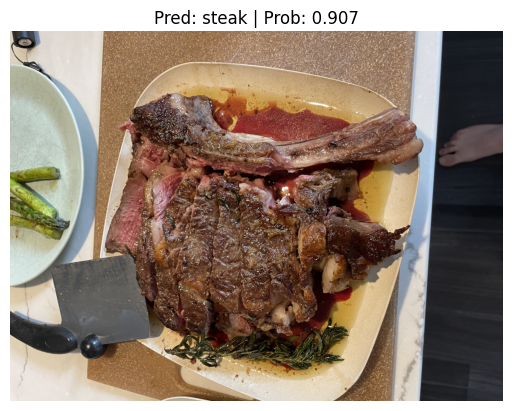

In [227]:
# Import function to make predictions on images and plot them
from predictions import pred_and_plot_image

pred_and_plot_image(model=best_model,
                    image_path="my_steak_image.jpg",
                    class_names=class_names)